In [1]:
import pandas as pd
import numpy as np

def fix_nan(csv_data):
    """

    :param csv_data: pd.DataFrame from test.csv
    :return: DataFrame with fixed nan in some columns and make data as datetime
    """
    csv_data["period_start_dt"] = pd.to_datetime(csv_data["period_start_dt"], format='%Y.%m.%d')
    #bad_column = ["PROMO1_FLAG","PROMO2_FLAG","NUM_CONSULTANT","AUTORIZATION_FLAG"]
    bad_column = csv_data.columns
    for replace_name in bad_column:
        csv_data[replace_name] = csv_data[replace_name].fillna(0.0)
    csv_data = csv_data.drop(columns=['PROMO2_FLAG', 'NUM_CONSULTANT'])
    return csv_data
    
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , promo_filters = [0, 1]
                    , target_var = 'demand'):
    
    # loop by filter variables and window
    for w in windows:

        # check whether filtered df in not empty
        if len(df) > 0:
            
            # lagged features calculation
            lf_df = df.set_index(['product_rk', 'store_location_rk', 'period_start_dt']).\
                 demand.groupby(level=['product_rk','store_location_rk']).\
                apply(lambda x: x.rolling(window=w, min_periods=1).agg(aggregation_methods))

            # provide lags tranformations
            for l in lags:
                new_names = {x: "lag{0}_wdw{1}_{2}".
                              format(l, w, x) for x in lf_df.columns }

                df = df.merge(lf_df.shift(l).reset_index().rename(columns = new_names),
                    how='left', on =['product_rk', 'store_location_rk', 'period_start_dt'] )

    return df

def process(csv_data):
    """

    :param csv_data: pd.DataFrame from test.csv
    :return: fixed DataFrame with one-hot for product and store
    """
    csv_data = fix_nan(csv_data)
    
    def make_column_one_hot(data, column_name):
        data = pd.merge(data, pd.get_dummies(data[column_name], prefix=column_name), left_index=True, right_index=True)
        return data
        #return data.drop(columns=column_name)

    def prepare_data(data):
        data = lagged_features(data)
        data = make_column_one_hot(data,"product_rk")
        data = make_column_one_hot(data,"store_location_rk")
        return data
        
    return prepare_data(csv_data)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from datetime import date
import scipy

In [3]:
raw_data = pd.read_csv("../demand-forecasting-in-retail/train.csv")

### Обработка данных для финального обучения
Предпологается разбиение категориальных данных (товар и магазин) в one-hot ячейки
Так же будут полезны лаговые операторы.

In [4]:
# data = fix_nan(raw_data)
final = process(raw_data)
for replace_name in final.columns:
    final[replace_name] = final[replace_name].fillna(0.0)
final

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,lag7_wdw7_mean,...,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380
0,0,40369,309,2016-12-19,29.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,40370,309,2016-12-19,64.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2,40372,309,2016-12-19,32.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3,40373,309,2016-12-19,10.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4,46272,309,2016-12-19,15.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,0.0,0.0,1000.00,1000.0,1.0,0.571429,...,0,0,0,0,0,0,0,0,0,1
35340,35538,40372,1380,2019-12-30,0.0,0.0,2000.00,2000.0,1.0,8.857143,...,0,0,0,0,0,0,0,0,0,1
35341,35539,40373,1380,2019-12-30,0.0,0.0,3000.00,3000.0,1.0,3.857143,...,0,0,0,0,0,0,0,0,0,1
35342,35540,46272,1380,2019-12-30,0.0,1.0,284.29,199.0,1.0,2.000000,...,0,0,0,0,0,0,0,0,0,1


Добавление в train set разметку значимых календарных событий (Новый Год, 14 февраля, 23 февраля, 8 марта, 9 мая, 1 сентября)

In [5]:
def add_holiday_flag(df, start_day, end_day, flag_name):
    nov_mar_series = pd.Series(pd.date_range(start_day, end_day))
    nov_mar_no_year = nov_mar_series.map(lambda x: x.strftime("%m-%d"))
    no_year_mask = df['no_year'].isin(nov_mar_no_year)
    df.loc[no_year_mask, flag_name] = 1
    df[flag_name] = df[flag_name].fillna(0)
    df[flag_name] = df[flag_name].astype(int)
    return df

In [6]:
final["no_year"] = final['period_start_dt'].map(lambda x: x.strftime("%m-%d"))

final = add_holiday_flag(final, "2013-02-12", "2013-02-16", "flag_14FEB")
final = add_holiday_flag(final, "2013-02-20", "2013-02-24", "flag_23FEB")
final = add_holiday_flag(final, "2013-03-06", "2013-03-10", "flag_8MAR")
final = add_holiday_flag(final, "2013-05-07", "2013-05-11", "flag_9MAY")
final = add_holiday_flag(final, "2013-08-07", "2013-09-30", "flag_1SEP")
final = add_holiday_flag(final, "2013-12-30", "2013-12-31", "flag_NEW_YEAR")
final = add_holiday_flag(final, "2013-01-01", "2013-01-03", "flag_NEW_YEAR")

final = final.drop(columns=['no_year'])

In [7]:
# np.unique(final[final.flag_NEW_YEAR == 1]['period_start_dt'].dt.strftime('%m-%d')).tolist()
final

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,lag7_wdw7_mean,...,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
0,0,40369,309,2016-12-19,29.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,40370,309,2016-12-19,64.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2,40372,309,2016-12-19,32.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3,40373,309,2016-12-19,10.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4,46272,309,2016-12-19,15.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,0.0,0.0,1000.00,1000.0,1.0,0.571429,...,0,0,0,1,0,0,0,0,0,1
35340,35538,40372,1380,2019-12-30,0.0,0.0,2000.00,2000.0,1.0,8.857143,...,0,0,0,1,0,0,0,0,0,1
35341,35539,40373,1380,2019-12-30,0.0,0.0,3000.00,3000.0,1.0,3.857143,...,0,0,0,1,0,0,0,0,0,1
35342,35540,46272,1380,2019-12-30,0.0,1.0,284.29,199.0,1.0,2.000000,...,0,0,0,1,0,0,0,0,0,1


In [8]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go


mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

In [9]:
len(final.columns)

94

In [10]:
final

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,lag7_wdw7_mean,...,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
0,0,40369,309,2016-12-19,29.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,40370,309,2016-12-19,64.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2,40372,309,2016-12-19,32.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3,40373,309,2016-12-19,10.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4,46272,309,2016-12-19,15.0,0.0,0.00,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,0.0,0.0,1000.00,1000.0,1.0,0.571429,...,0,0,0,1,0,0,0,0,0,1
35340,35538,40372,1380,2019-12-30,0.0,0.0,2000.00,2000.0,1.0,8.857143,...,0,0,0,1,0,0,0,0,0,1
35341,35539,40373,1380,2019-12-30,0.0,0.0,3000.00,3000.0,1.0,3.857143,...,0,0,0,1,0,0,0,0,0,1
35342,35540,46272,1380,2019-12-30,0.0,1.0,284.29,199.0,1.0,2.000000,...,0,0,0,1,0,0,0,0,0,1


In [11]:
data = final.drop('period_start_dt',axis=1)

In [12]:
# для предсказания нужны:
# l, b за прошлый период
# s за m периодов назад
# y_hat за текущий период
def compute_components(X, known_len, m=52):
    alpha = beta = gamma = 0.0005
    n = X.shape[0]
    l = np.zeros(n+1)
    b = np.zeros(n+1)
    s = np.zeros(n+1)
    y_hat = np.zeros(n+1)
    l[0] = sum(X[0:known_len:m]) / (known_len//m + 1) + 0.001
    if n < m:
        l[0] = 1
    for i in range(min(m, n)):
        s[i] = X[i]/l[0]
    if 2*m < n:
        #print(X[m:2*m].sum(), X[0:m].sum())
        b[0] = np.exp(1/m*(np.log(X[m:2*m].sum() + 0.001) - np.log(X[0:m].sum() + 0.001)))
    else:
        b[0] = 1
    for t in range(1, n):
        l[t] = alpha*y_hat[t]
        if (t >= m):
            l[t] /= (s[t-m] + 0.01)
            s[t] = gamma*X[t]/(l[t-1]*b[t-1]) + (1 - gamma)*s[t-m]
        l[t] += (1 - alpha)*l[t-1]*b[t-1]
        b[t] = beta*l[t]/(l[t-1] + 0.001) + (1-beta)*b[t-1]
        y_hat[t+1] = l[t]*b[t]
        if (t - m + 1 >= 0):
            y_hat[t+1] *= s[t-m+1]
    
    return l, b, s, y_hat

In [13]:
TRAIN_SIZE = 60

def add_components(data):
    products = data.product_rk
    stores = data.store_location_rk
    data['l'] = 0
    data['s'] = 1
    data['b'] = 0
    data['y'] = 0

    for prod in products.unique():
        for store in stores.unique():
            X_curr = data[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna()]
            if X_curr.shape[0] == 0:
                continue
            m = 52
            n = X_curr.demand.shape[0]
            l, b, s, y_hat = compute_components(X_curr.demand.to_numpy(), TRAIN_SIZE)
            #print(X_curr.columns)
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'y'] = y_hat[:-1]
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'l'] = l[1:]
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'b'] = b[1:]
            s = [1]*m + list(s)
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 's'] = s[:-m-1]

In [27]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

def split(ds, scaler):
    y = ds.demand.values.reshape(-1, 1)
    x = scaler.fit_transform(ds.drop('demand',axis=1))
    #x = ds.drop('demand',axis=1).values
    ts = TimeseriesGenerator(x[:TRAIN_SIZE], y[:TRAIN_SIZE], 7) 
    return ts, x, y, ds
def make_ds(dataset):
    g = dataset.groupby(['product_rk','store_location_rk'])
    gg = np.array(g)[:,1]
    scalers = []
    for i in range(gg.shape[0]):
        if gg[i].shape[0] <= 10:
            continue
        ds = gg[i]
        scalers.append(MinMaxScaler(feature_range=(0, 1)))
        add_components(ds)
        ds.drop(['product_rk','store_location_rk'], axis=1, inplace=True)
        ds.reset_index(drop=True, inplace=True)
    return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers

len(make_ds(data)[0])


<ipython-input-27-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-27-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers


239

In [15]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [16]:
#!XL
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cpu


In [17]:
train_transform = transforms.Compose([transforms.RandomSizedCrop(size=(128, 128),
                                                                 scale=(0.25, 1.),
                                                                 ratio=(0.5, 2.0)),
                                                                 transforms.ToTensor()])

transform = transforms.Compose([transforms.Resize((128, 128)),
                                    transforms.ToTensor()])

/Users/maxim/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [28]:
ds = make_ds(data)[0]

<ipython-input-27-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-27-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers


In [29]:
ds.shape

(239, 4)

In [30]:
#!XL
batch_size = 50
train_batch_gen = torch.utils.data.DataLoader(ds[0], batch_size=batch_size)

val_batch_gen = torch.utils.data.DataLoader(ds[0], batch_size=batch_size, shuffle=True)


In [31]:
#!XL
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.ylim(0, 3)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('F1_score', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('F1_score', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()
    
#!XL
def train_with_aug(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''
    
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        temp = 0
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            
            # Применяем аугментацию
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += f1_score(y_pred, y_batch.cpu().numpy(), average='macro')
            
            if temp % 15 == 0:
                print("PRED:", y_pred)
                print("TRUE:", y_batch.cpu().numpy())
                print(train_acc*100, temp, len(train_batch_gen))
            temp += 1

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        for g in optimizer.param_groups:
            g['lr'] *= 0.94
        if epoch % 15 == 0 and epoch != 0:
            for g in optimizer.param_groups:
                g['lr'] /= 2.
            
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += f1_score(y_pred, y_batch.cpu().numpy(), average='macro')

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [34]:
#!g1.4
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding.from_pretrained(weights)
        self.emb.weight.requires_grad=False
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=1024, kernel_size=3)
        self.dropout1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.globalmaxpool = GlobalMaxPooling()
        self.dense = nn.Linear(512, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = nn.ELU()(h)
        h = self.dropout1(h)
        h = self.conv2(h)
        h = nn.ELU()(h)
        h = self.dropout2(h)
        h = self.globalmaxpool(h)
        h = self.dense(h)
        
        return h

In [35]:
#!g1.4
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding.from_pretrained(weights)
        self.emb.weight.requires_grad=False
        self.rnn = nn.LSTM(input_size=300, hidden_size=256, bidirectional=True, num_layers=1)
        self.globalmaxpool = GlobalMaxPooling()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(512, 1024)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dense = nn.Linear(1024, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
#         h = torch.transpose(h, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        h, _ = self.rnn(h)
        h = torch.transpose(h, 1, 2)
        h = self.globalmaxpool(h)
#         h = nn.BatchNorm1d(512)(h)
        h = nn.ELU()(h)
        h = self.dropout1(h)
        h = self.fc1(h)
        h = nn.ELU()(h)
        h = self.dropout2(h)
        h = self.dense(h)
        return h

In [32]:
#!XL
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cpu


In [22]:
def e2e_train(data, model, optimizer, loss, epochs):
    ds = make_ds(data)
    model.compile(optimizer=optimizer, loss=loss)
    hist = model.fit(ds[0][0], epochs=epochs)
    
    hist = hist.history['loss']
    plt.plot(hist)
    plt.show()
    test =ds[0][0][1]
    y = make_ds(data)[0][0][2]
    yhat = []
    n = test.shape[0]
    for i in range(10, n):
        yhat.append(model.predict(test[i-10:i].reshape(1, 10, -1))[0][-1])
    
    plt.figure(figsize=(20, 12))
    plt.plot(y, label='true')
    plt.plot(yhat,label='pred')
    plt.legend()
    plt.show()

In [37]:
#!g1.4
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens, n_cat_features):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        self.categ_dense1 = nn.Linear(n_cat_features, 512)
        self.categ_dense2 = nn.Linear(512, 64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense1 = nn.Linear(3*64, 1024)
        self.dense2 = nn.Linear(1024, 512)
        self.dense3 = nn.Linear(512, 1)
        
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_dense1(cat_features)
        cat_h = nn.ELU()(cat_h)
        cat_h = self.categ_dense2(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dense1(joint_h)
        joint_h = nn.ELU()(joint_h)
        joint_h = self.dense2(joint_h)
        joint_h = nn.ELU()(joint_h)
        joint_h = self.dense3(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0]

In [39]:
#!g1.4
# test it on one batch
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
#!g1.4
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

In [ ]:
#!g1.4
from collections import defaultdict
from collections import OrderedDict

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import clear_output

from sklearn.datasets import load_boston

In [ ]:
#!g1.4
from collections import defaultdict
from collections import OrderedDict

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import clear_output

from sklearn.datasets import load_boston

In [40]:
#!g1.4

num_epochs = 300
max_len = 100
batch_size = 32
batches_per_epoch = 100
history = defaultdict(lambda: defaultdict(list))
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_acc = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.detach().cpu().numpy()
        train_acc += compute_mae(reference, prediction).data.detach().cpu().numpy()
        train_batches += 1
    
    history['loss']['train'].append(train_loss / train_batches)
    history['acc']['train'].append(train_acc / train_batches)
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_acc / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_acc = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.detach().cpu().numpy()
        val_acc += compute_mae(reference, prediction).data.detach().cpu().numpy()
        val_batches += 1

    history['loss']['val'].append(val_loss / val_batches)
    history['acc']['val'].append(val_acc / val_batches)
    
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_acc / val_batches))
    print('\n\n')
    clear_output()
    plot_learning_curves(history)

In [23]:
c=0
hist = []
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='smape')
ds = make_ds(data)[0]
for _ in range(300):
    print(_)
    for i in ds:
        for series in i[0]:
            hist.append(model.train_on_batch(series[0], series[1]))

<ipython-input-14-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-14-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers


0


ValueError: in user code:

    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:186 __call__
        self.build(y_pred)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:139 build
        self._losses = nest.map_structure(self._get_loss_object, self._losses)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:262 _get_loss_object
        loss = losses_mod.get(loss)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1899 get
        return deserialize(identifier)
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1854 deserialize
        return deserialize_keras_object(
    /Users/maxim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:377 deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: smape


# LSTM with all data (94 features), relu activations and MSE loss.

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()

e2e_train(data, model, optimizer, "smape", 600)

<ipython-input-14-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-14-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type TimeseriesGenerator).

# LSTM with different dimensionality of the output space

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(5, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()

e2e_train(ds, model, optimizer, "mse", 600)

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

# LSTM with ELU func. activation, 3000 epochs and less lr.

Epoch 1/3000
1/1 [==============================] - 6s 6s/step - loss: 3425.8008
Epoch 2/3000
1/1 [==============================] - 0s 29ms/step - loss: 3424.4634
Epoch 3/3000
1/1 [==============================] - 0s 28ms/step - loss: 3423.1111
Epoch 4/3000
1/1 [==============================] - 0s 31ms/step - loss: 3421.7126
Epoch 5/3000
1/1 [==============================] - 0s 30ms/step - loss: 3420.2444
Epoch 6/3000
1/1 [==============================] - 0s 36ms/step - loss: 3418.6860
Epoch 7/3000
1/1 [==============================] - 0s 32ms/step - loss: 3417.0227
Epoch 8/3000
1/1 [==============================] - 0s 27ms/step - loss: 3415.2393
Epoch 9/3000
1/1 [==============================] - 0s 27ms/step - loss: 3413.3218
Epoch 10/3000
1/1 [==============================] - 0s 27ms/step - loss: 3411.2554
Epoch 11/3000
1/1 [==============================] - 0s 27ms/step - loss: 3409.0244
Epoch 12/3000
1/1 [==============================] - 0s 26ms/step - loss: 3406.6143
Epo

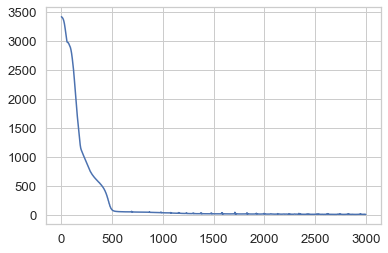

<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-59-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers
<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

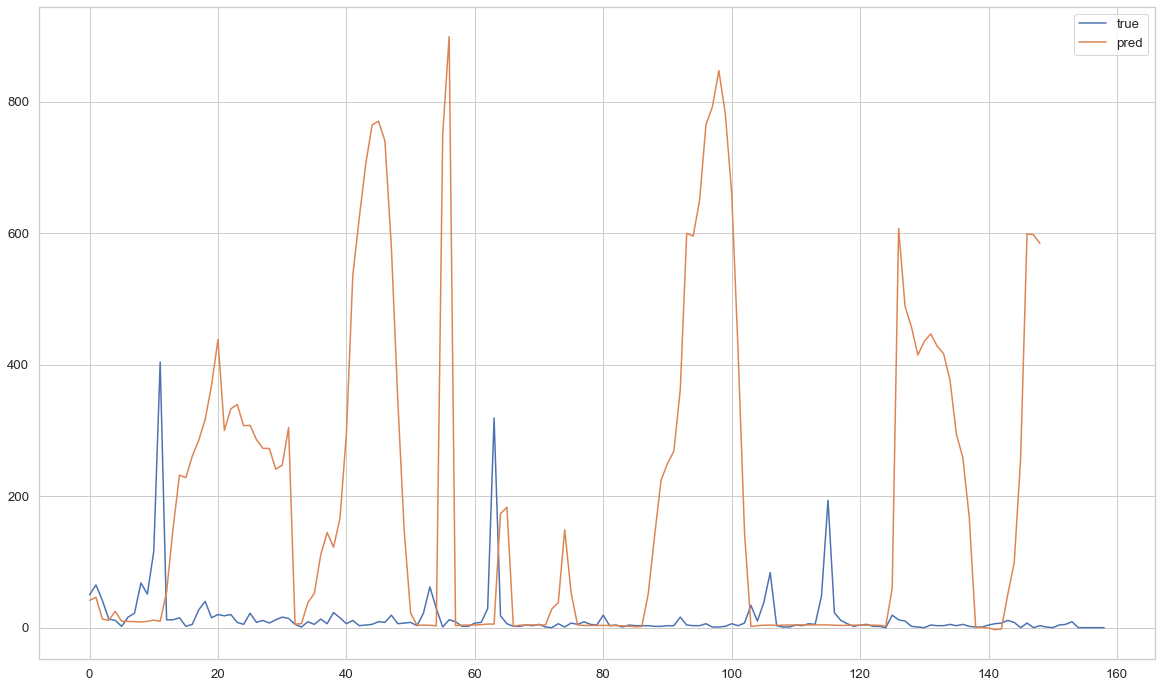

In [69]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(5, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

e2e_train(ds, model, optimizer, "mse", 3000)

# LSTM with MAPE

Epoch 1/2000
1/1 [==============================] - 4s 4s/step - loss: 1414.0782
Epoch 2/2000
1/1 [==============================] - 0s 19ms/step - loss: 195162.1094
Epoch 3/2000
1/1 [==============================] - 0s 20ms/step - loss: 169568.1406
Epoch 4/2000
1/1 [==============================] - 0s 20ms/step - loss: 94350.2812
Epoch 5/2000
1/1 [==============================] - 0s 20ms/step - loss: 26003.0391
Epoch 6/2000
1/1 [==============================] - 0s 21ms/step - loss: 37929.8594
Epoch 7/2000
1/1 [==============================] - 0s 23ms/step - loss: 45229.8164
Epoch 8/2000
1/1 [==============================] - 0s 24ms/step - loss: 24589.2520
Epoch 9/2000
1/1 [==============================] - 0s 22ms/step - loss: 14350.8242
Epoch 10/2000
1/1 [==============================] - 0s 20ms/step - loss: 17598.4062
Epoch 11/2000
1/1 [==============================] - 0s 20ms/step - loss: 2572.2300
Epoch 12/2000
1/1 [==============================] - 0s 20ms/step - loss: 37

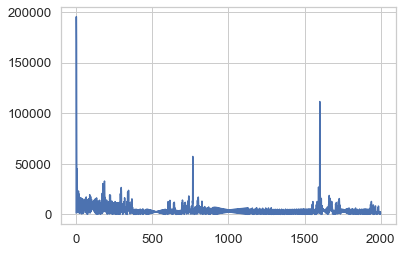

<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-59-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers
<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

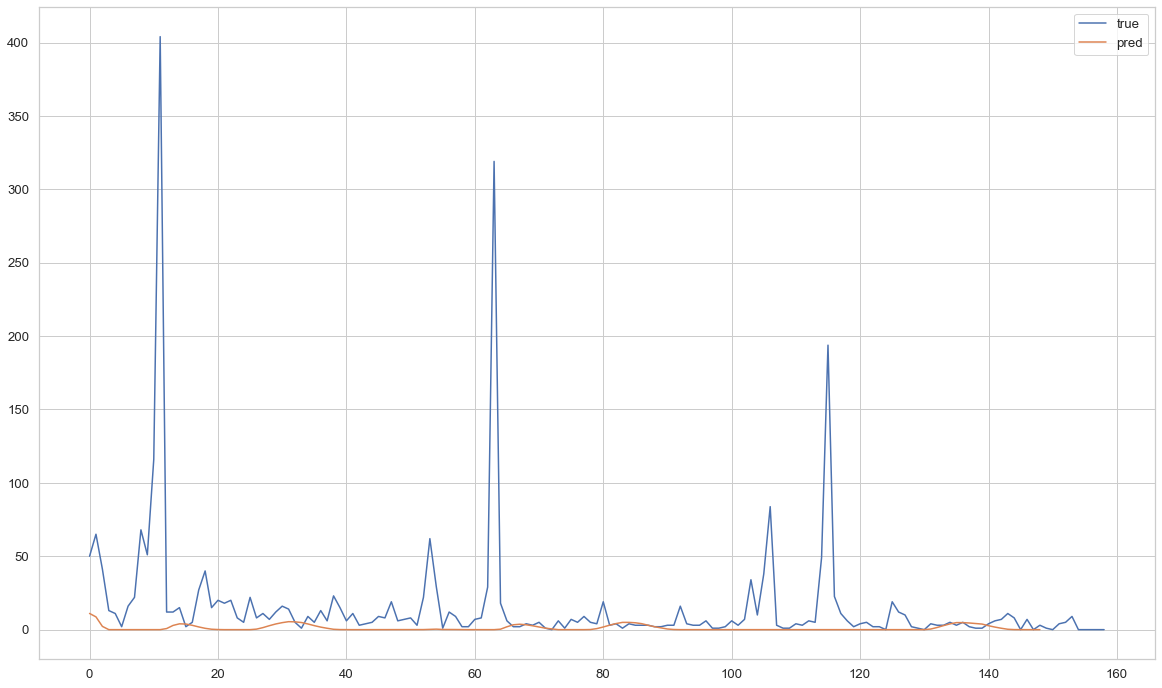

In [70]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(5, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()

e2e_train(ds, model, optimizer, "mape", 2000)

# LSTM MAPE with more epochs and neurons in Dense layer.

Epoch 1/2000
1/1 [==============================] - 4s 4s/step - loss: 73566.9375
Epoch 2/2000
1/1 [==============================] - 0s 20ms/step - loss: 103250.6797
Epoch 3/2000
1/1 [==============================] - 0s 19ms/step - loss: 67254.1641
Epoch 4/2000
1/1 [==============================] - 0s 22ms/step - loss: 9231.7656
Epoch 5/2000
1/1 [==============================] - 0s 21ms/step - loss: 12691.3271
Epoch 6/2000
1/1 [==============================] - 0s 20ms/step - loss: 20104.2363
Epoch 7/2000
1/1 [==============================] - 0s 23ms/step - loss: 13657.6289
Epoch 8/2000
1/1 [==============================] - 0s 22ms/step - loss: 16384.4199
Epoch 9/2000
1/1 [==============================] - 0s 22ms/step - loss: 16817.5762
Epoch 10/2000
1/1 [==============================] - 0s 22ms/step - loss: 6233.2627
Epoch 11/2000
1/1 [==============================] - 0s 21ms/step - loss: 4830.8369
Epoch 12/2000
1/1 [==============================] - 0s 22ms/step - loss: 1725

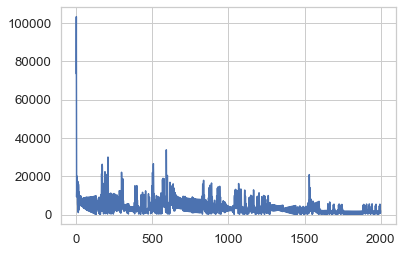

<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-59-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers
<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

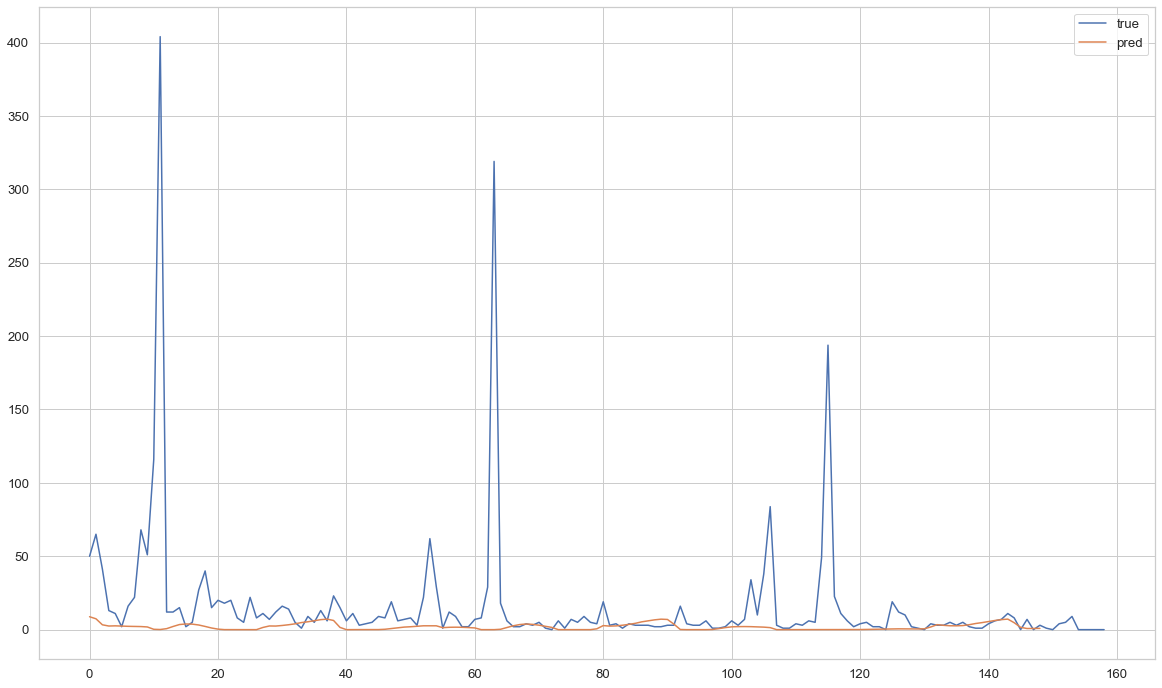

In [71]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(5, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

e2e_train(ds, model, optimizer, "mape", 2000)

# LSTM with MAE

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 20.1168
Epoch 2/300
1/1 [==============================] - 0s 29ms/step - loss: 20.0991
Epoch 3/300
1/1 [==============================] - 0s 31ms/step - loss: 20.0817
Epoch 4/300
1/1 [==============================] - 0s 35ms/step - loss: 20.0655
Epoch 5/300
1/1 [==============================] - 0s 36ms/step - loss: 20.0502
Epoch 6/300
1/1 [==============================] - 0s 31ms/step - loss: 20.0342
Epoch 7/300
1/1 [==============================] - 0s 41ms/step - loss: 20.0164
Epoch 8/300
1/1 [==============================] - 0s 22ms/step - loss: 19.9966
Epoch 9/300
1/1 [==============================] - 0s 21ms/step - loss: 19.9746
Epoch 10/300
1/1 [==============================] - 0s 22ms/step - loss: 19.9502
Epoch 11/300
1/1 [==============================] - 0s 21ms/step - loss: 19.9229
Epoch 12/300
1/1 [==============================] - 0s 23ms/step - loss: 19.8923
Epoch 13/300
1/1 [=====================

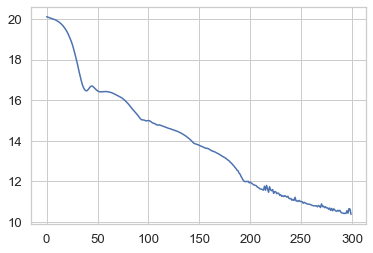

<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-59-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers
<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

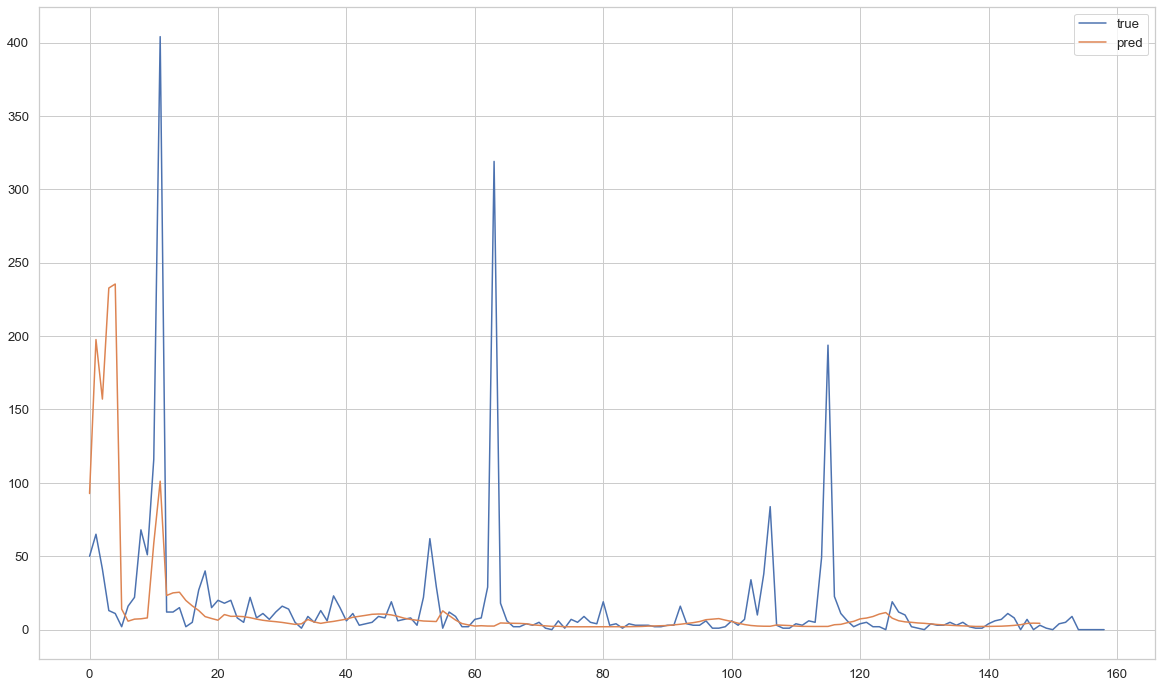

In [72]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(5, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()

e2e_train(ds, model, optimizer, "mae", 300)

# LSTM with DropOut

Epoch 1/600
1/1 [==============================] - 5s 5s/step - loss: 3426.0916
Epoch 2/600
1/1 [==============================] - 0s 37ms/step - loss: 3421.5564
Epoch 3/600
1/1 [==============================] - 0s 40ms/step - loss: 3406.9250
Epoch 4/600
1/1 [==============================] - 0s 49ms/step - loss: 3372.6985
Epoch 5/600
1/1 [==============================] - 0s 44ms/step - loss: 3310.2986
Epoch 6/600
1/1 [==============================] - 0s 45ms/step - loss: 3225.6865
Epoch 7/600
1/1 [==============================] - 0s 44ms/step - loss: 3112.4609
Epoch 8/600
1/1 [==============================] - 0s 74ms/step - loss: 3045.7124
Epoch 9/600
1/1 [==============================] - 0s 124ms/step - loss: 3031.4641
Epoch 10/600
1/1 [==============================] - 0s 98ms/step - loss: 3027.0742
Epoch 11/600
1/1 [==============================] - 0s 79ms/step - loss: 2987.6064
Epoch 12/600
1/1 [==============================] - 0s 36ms/step - loss: 2982.1116
Epoch 13/600
1

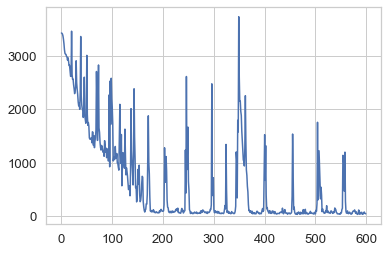

<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gg = np.array(g)[:,1]
<ipython-input-59-4118b59f2f69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers
<ipython-input-59-4118b59f2f69>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

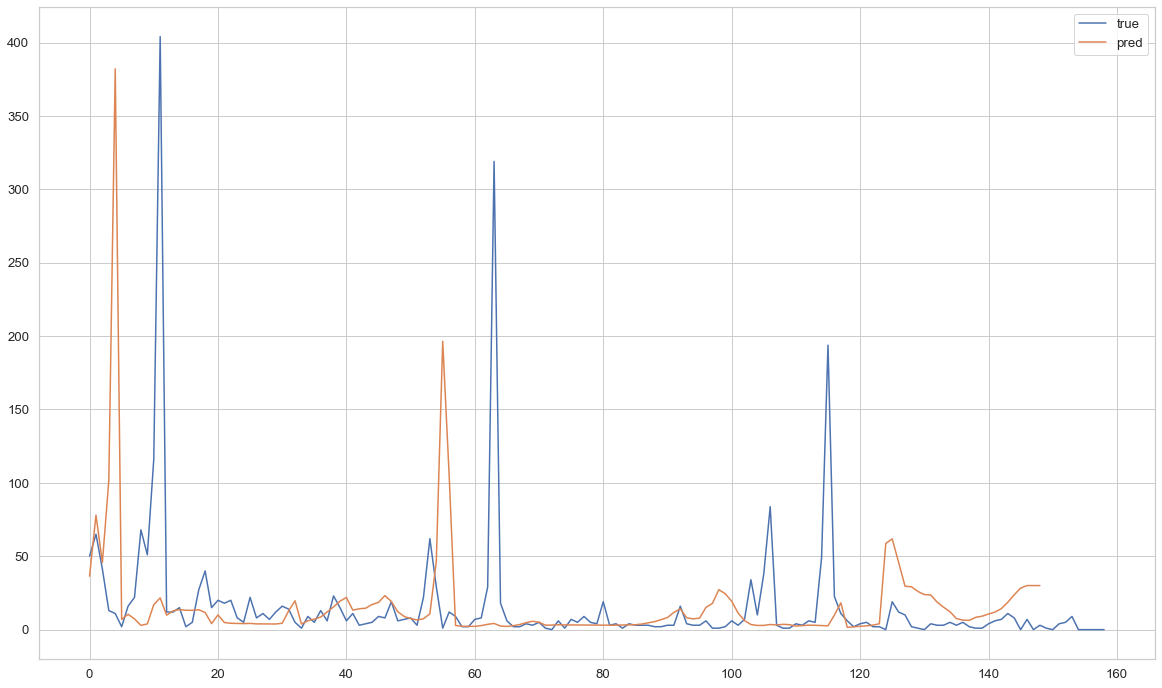

In [79]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(None,94), return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002)

e2e_train(ds, model, optimizer, "mse", 600)